In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [97]:
in_channels = 3
num_classes = 10
learning_rate = 0.001
batch_size =  32
epochs = 12

In [98]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     torchvision.transforms.RandomHorizontalFlip(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [99]:
train_data = datasets.CIFAR10(root='dataset/', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = datasets.CIFAR10(root='dataset/', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


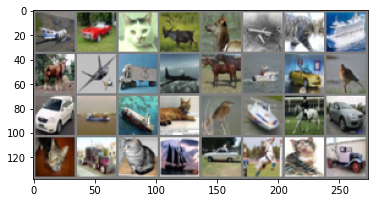

In [100]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [101]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [102]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
    self.bn4 = nn.BatchNorm2d(256)
    self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
    self.bn5 = nn.BatchNorm2d(512)
    self.fc1 = nn.Linear(128*4*4, 512)
    self.fc2 = nn.Linear(512, 256)
    self.drop = nn.Dropout()
    self.fc3 = nn.Linear(256, 10)

  def forward(self, x):
    # -> n, 3, 32, 32
    x = self.pool(F.relu(self.bn1(self.conv1(x)))) 
    x = self.pool(F.relu(self.bn2(self.conv2(x))))  
    x = self.pool(F.relu(self.bn3(self.conv3(x))))
    x = self.pool(F.relu(self.bn4(self.conv4(x))))
    x = F.relu(self.bn5(self.conv5(x)))
    x = torch.flatten(x,1)     # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.drop(x) 
    x = self.fc3(x) 
    return x

model = ConvNet().to(device)

In [103]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [104]:
#train block
for epoch in range(epochs):
  for batch_idx, (images,labels) in enumerate(tqdm(train_loader)):
    images = images.to(device=device)
    labels = labels.to(device=device)

    predictions = model(images)
    loss = criterion(predictions, labels)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

100%|██████████| 1563/1563 [05:16<00:00,  4.94it/s]


In [105]:
#save load model
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)


In [106]:
net = ConvNet()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

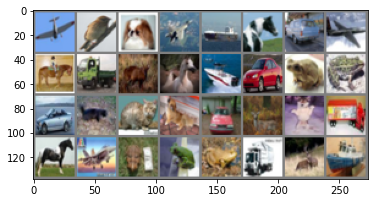

GroundTruth:  plane bird  dog   plane ship  horse car   plane
Predicted:  plane bird  dog   plane ship  horse car   plane


In [107]:
#example predictions
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(8)))

In [108]:
#evaluate model
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for batch_id, (images,labels) in enumerate(test_loader):
        images=images.to(device=device)
        labels=labels.to(device=device)
        # calculate outputs by running images through the network
        predictions = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(predictions.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 81 %


In [109]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for batch_id, (images,labels) in enumerate(test_loader):
        images=images.to(device=device)
        labels=labels.to(device=device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 86.6 %
Accuracy for class: car   is 94.8 %
Accuracy for class: bird  is 68.4 %
Accuracy for class: cat   is 62.4 %
Accuracy for class: deer  is 81.8 %
Accuracy for class: dog   is 73.3 %
Accuracy for class: frog  is 86.0 %
Accuracy for class: horse is 87.5 %
Accuracy for class: ship  is 87.5 %
Accuracy for class: truck is 84.0 %
